# ASSAY analysis

colaboration between damian industries and shi lab

## imports

In [1]:
# imports:
# main contains all the functions specifically for the Assay analysis
#from main import *

# matplotlib as plotting library:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#
import pprint
import pandas as pd
import numpy as np

from ipywidgets import widgets
from assaypy import *

In [2]:
# %pip install -U assaypy
# %pip install assaypy==0.0.2
%pip freeze | grep assaypy

assaypy==0.0.3
Note: you may need to restart the kernel to use updated packages.


In [3]:
plt.rcParams["figure.figsize"] = (10,8)

In [4]:
# okay lets start by choosing the excel file we want to analysis: 
assay_run_1 =  path_to_xlsx('tests/testfiles/270123 CABP Quant Exp no header.xlsx')
print('using assays xlsx file: ',assay_run_1)

using assays xlsx file:  tests/testfiles/270123 CABP Quant Exp no header.xlsx


In [5]:
# save all worksheets as pandas dataframes:
dfs1 = excel_to_pandas(assay_run_1)

100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.32s/it]

RAW DATA 57


In [6]:
print_data_structure(dfs1)

data structure with columns found:
   
RAW DATA
['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']
number of columns: 33
  


## remove for analysis:
### remove whole worksheet/assay:

In [7]:
print('tick box to remove Assays:')
checkboxes = [widgets.Checkbox(value=False, description=label) for label in list(dfs1)]
display(widgets.VBox(children=checkboxes))

tick box to remove Assays:


In [8]:
remove_assays = []
for i in range(0, len(checkboxes)):
    if checkboxes[i].value == True:
        remove_assays = remove_assays + [checkboxes[i].description]
for n in remove_assays:
     del dfs1[n]
print('removed assays:', remove_assays)

removed assays: []


### remove columns:

be careful, might kill dublet/triplet 

In [9]:
# del dfs1['Assay 1 No Shaking']['A2']

## attach triplet/dublet information to Assays

In [11]:
dubtrip = attach_dubtrip(dfs1)

--
Dublet/Triplet for - RAW DATA -: 3
 
final:

{'RAW DATA': 3}


In [12]:
## only run this cell if you want to redo a specific Assay dublet/triplet:
change_assay_dubtrip(dfs1, dubtrip)

which assay do you want to change? 
 
nothing changed
still:

{'RAW DATA': 3}


## grouping wells

grouping to previous determined Dub / Trip states

In [13]:
groups = group_wells(dfs1, dubtrip)

grouping wells with provided dubtrip data:
   
{'RAW DATA': 3}
   
RAW DATA
A1-A2-A3
A4-A5-A6
A7-A8-A9
B1-B2-B3
B4-B5-B6
B7-B8-B9
B10-B11-B12
C1-C2-C3
C4-C5-C6
C7-C8-C9
C10-C11-C12
 


## calculate slopes

`analyse_all(dfs1, interval = 200, time0=True, endtime=1000)`

time0 if `True` starts slope analysis after reaction starts, takes also time in seconds

In [76]:
special_times = {
    'RAW DATA': {
        'B4-B5-B6': (10,True,1500),
        'B7-B8-B9': (10,True,1500),
    }
}

In [79]:
list(special_times['RAW DATA'])

['B4-B5-B6', 'B7-B8-B9']

In [91]:

def analyse_all(dfs, interval:int = 100, time0:bool = True, endtime:int = None, special_times:dict=None) -> dict:
    '''
    interval = interval in seconds for slope analysis 
    dubtrip  = dublicate or triplete data given, it seperates t
    time0 = start time of analysis, if true its starts after reaction starts but we can also give a number
    endtime = time in seconds where analysis ends
    '''

    all_slopes = dict()
    all_errors = dict()

    # make regression for all assays:
    for assay in dfs: 
        header = list(dfs[assay])
        for t in ['Cycle Nr.', 'Time [s]', 'CO2 %', 'O2 %', 'Temp. [°C]']:
            header.remove(t)
        new_header = header.copy()
        new_header.insert(0,'Time [s]')
        
        # timewise slicing for whole assay:
        df_sliced = dfs[assay]
        if time0 == True:
            time0_ = get_time_zero(dfs[assay])
            df_sliced = df_sliced[df_sliced['Time [s]'] > time0_]
        else:
            try:
                time0_ = time0
                df_sliced = df_sliced[df_sliced['Time [s]'] > time0_]
            except:
                time0_ = 0
                df_sliced = dfs[assay]

        if endtime == None:
            df_sliced = df_sliced
        else:
            try:
                endtime_ = endtime
                df_sliced = df_sliced[df_sliced['Time [s]'] < endtime_]
            except:
                print('couldnt slice endtime of experiment. analysis ending at {}s'.format(df_sliced['Time [s]']))     

        _all_slopes = list()
        _all_errors = list()
        # slice from start to end point in seconds:
        for tt in range(0, int(np.max(df_sliced['Time [s]'])/interval)):
            try:
                _slope = list()
                _error = list()
                for well in header:
                    if special_times != None:
                        for groups in list(special_times[assay]):
                            if well in groups:
                                special_times[assay][groups] = i, t0, e
                                
                                df_sliced_ = df_sliced[df_sliced['Time [s]'] >= tt*i+t0]
                                df_sliced_ = df_sliced_[df_sliced_['Time [s]'] < (tt+1)*i+t0]
                                    
                    else:
                        df_sliced_ = df_sliced[df_sliced['Time [s]'] >= tt*interval+time0_]
                        df_sliced_ = df_sliced_[df_sliced_['Time [s]'] < (tt+1)*interval+time0_]
                    x = df_sliced_['Time [s]']
                    y = df_sliced_[well]
                    result = linregress(x, y)
                    _slope.append(result.slope)
                    _error.append(result.stderr)
                _slope.insert(0,float(tt*interval+time0_))
                _error.insert(0,float(tt*interval+time0_))
            except:
                pass #print('wasnt working')
            
            _all_slopes.append(_slope)
            _all_errors.append(_error)
        all_slopes[assay] = pd.DataFrame(_all_slopes,columns=new_header).dropna()
        all_errors[assay] = pd.DataFrame(_all_errors,columns=new_header).dropna()
    return all_slopes, all_errors


In [92]:
s,t,u = special_times['RAW DATA']['B7-B8-B9'] 

In [93]:
s

10

In [94]:
analyse = analyse_all(dfs1, interval = 50, time0 = 300, endtime = 500, special_times=special_times)
#slopes = analyse[0]
#errslo = analyse[1]

ValueError: 34 columns passed, passed data had 0 columns

# export the analysis

In [71]:
with pd.ExcelWriter('output_slopes.xlsx') as writer:  
    for assay in list(slopes):
        slopes[assay].to_excel(writer, sheet_name=assay)

## plot slopes

dfs1 = DataFrame with all data loaded

groups = information about grouping of the data

exclude = exclude e.g. 'Assay 1 No Shaking' e.g. or 3 for exluding Triplets

`plot_assays_and_slopes(dfs1, groups, exclude = [3, 'Assay 3 Shaking'])`


replace `%matplotlib inline` with `%matplotlib widget` for interactive plot


RAW DATA


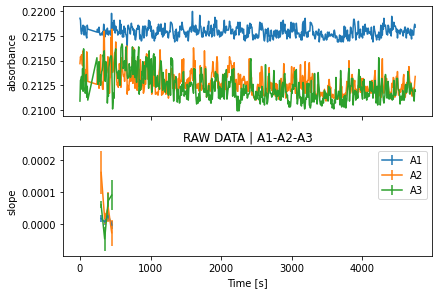

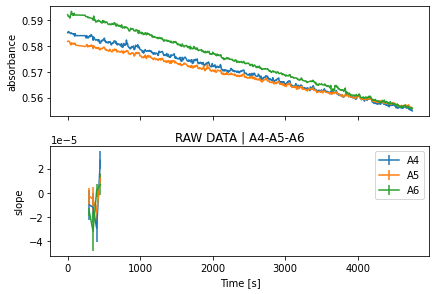

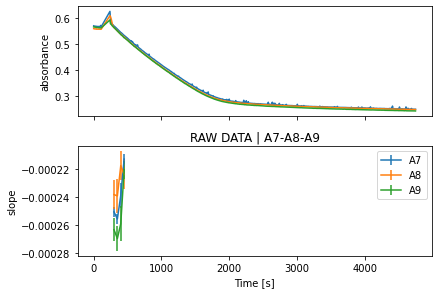

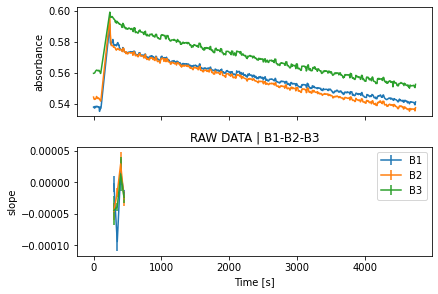

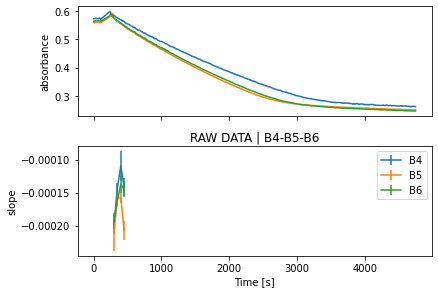

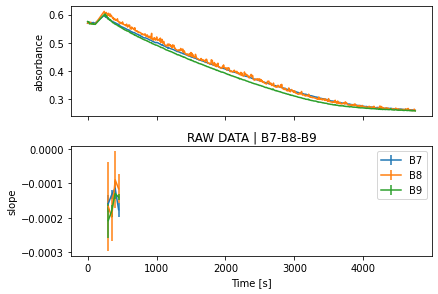

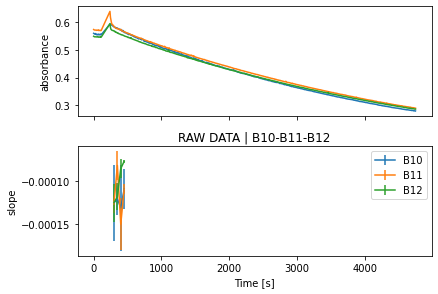

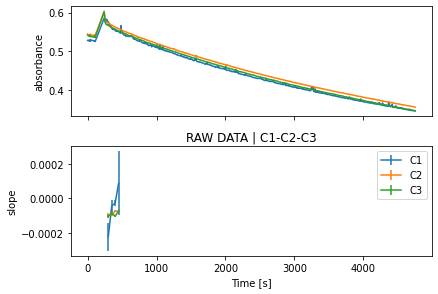

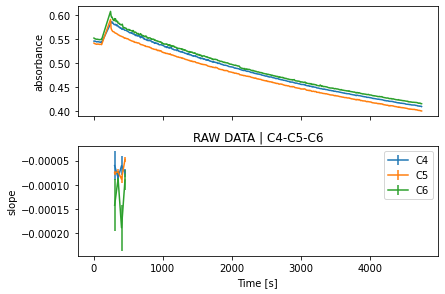

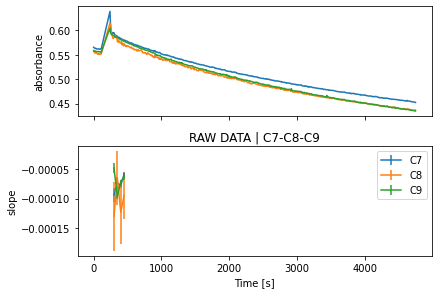

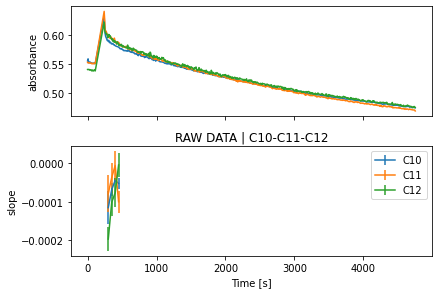

In [84]:
%matplotlib inline
plot_assays_and_slopes(dfs1, 
                       groups, 
                       slopes, 
                       errslo, 
                       exclude = [],
                       )

## attach mol information to CABP assay where n = 2

input for Mol data for each well pair

enzymes can be named, but must be unique per essay

A1-3 blank
A4-6 no RuBP
A7-9 0 CABP
B1-3 0.1 
B4-6 0.01
B7-9 0.015
B10-12 0.02
C1-3 0.025
C4-6 0.03
C7-9 0.035

In [44]:
cabp_mol = {
    'RAW DATA': {
        'enzyme1':{
#            'A1-A2-A3': 0,
#            'A4-A5-A6': 0,
            'A7-A8-A9': 0,
            'B1-B2-B3': 0.1,
            'B4-B5-B6': 0.01,
            'B7-B8-B9': 0.015,
            'B10-B11-B12': 0.02,
            'C1-C2-C3': 0.025,
            'C4-C5-C6': 0.03,
            'C7-C8-C9': 0.035,
            'C10-C11-C12': 0.04,
        }
    }
}


# duplicate list into wells: 

for assay in list(cabp_mol):
    for enzyme in list(cabp_mol[assay]):
        for wellpair in list(cabp_mol[assay][enzyme]):
            for well in wellpair.split('-'):
                cabp_mol[assay][enzyme][well] = cabp_mol[assay][enzyme][wellpair]
            if len(wellpair) > 3:
                del cabp_mol[assay][enzyme][wellpair]
            
pprint.pprint(cabp_mol, sort_dicts=False )

{'RAW DATA': {'enzyme1': {'A7': 0,
                          'A8': 0,
                          'A9': 0,
                          'B1': 0.1,
                          'B2': 0.1,
                          'B3': 0.1,
                          'B4': 0.01,
                          'B5': 0.01,
                          'B6': 0.01,
                          'B7': 0.015,
                          'B8': 0.015,
                          'B9': 0.015,
                          'B10': 0.02,
                          'B11': 0.02,
                          'B12': 0.02,
                          'C1': 0.025,
                          'C2': 0.025,
                          'C3': 0.025,
                          'C4': 0.03,
                          'C5': 0.03,
                          'C6': 0.03,
                          'C7': 0.035,
                          'C8': 0.035,
                          'C9': 0.035,
                          'C10': 0.04,
                          'C11': 0.04,
          

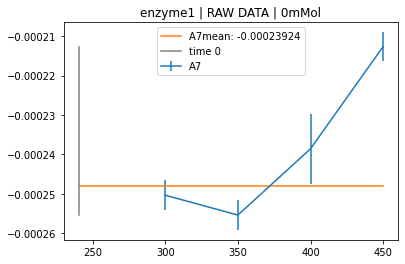

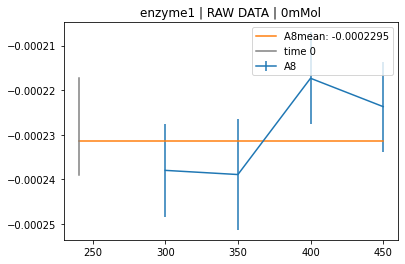

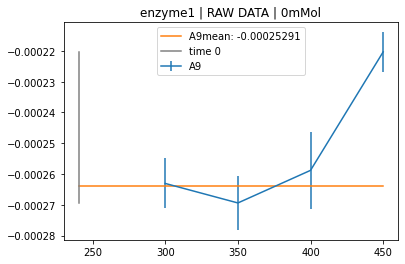

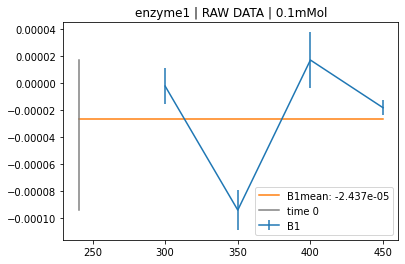

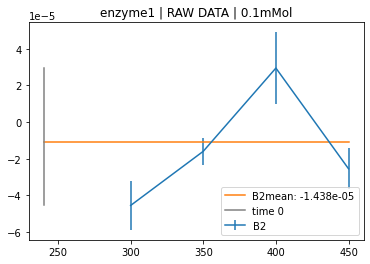

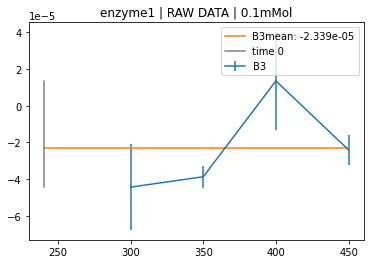

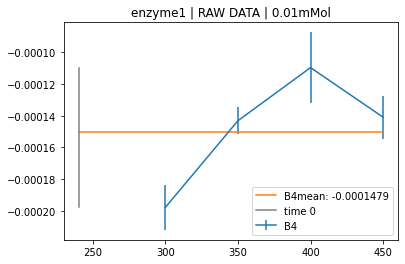

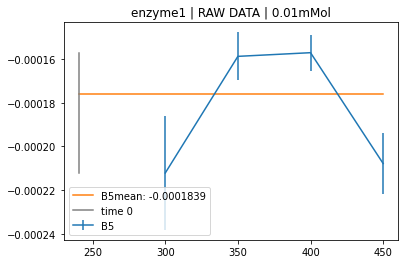

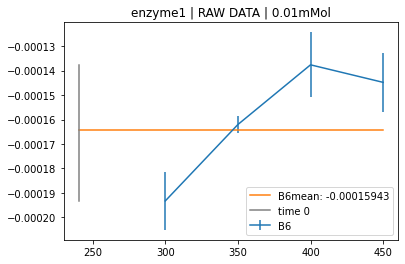

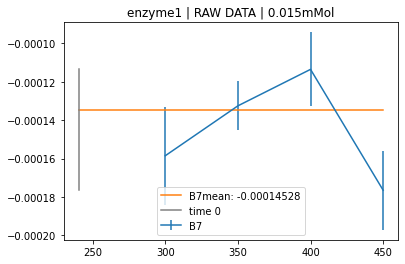

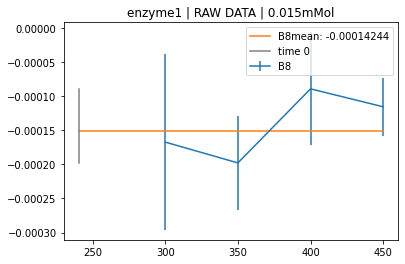

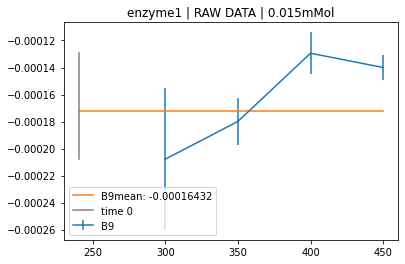

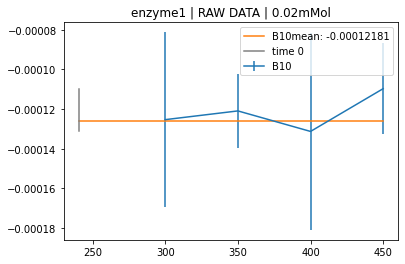

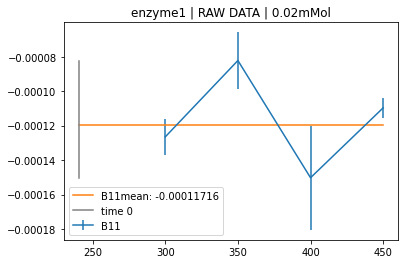

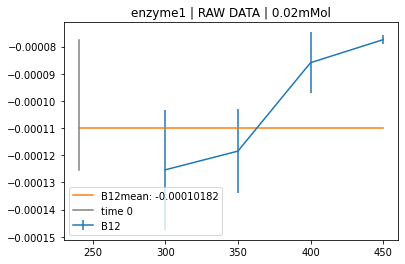

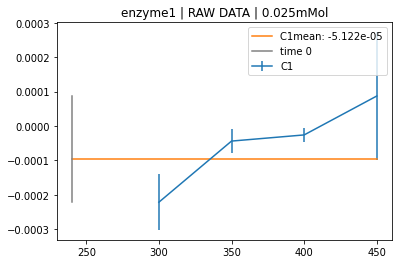

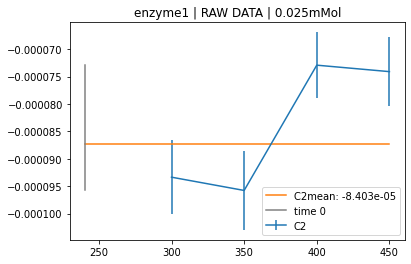

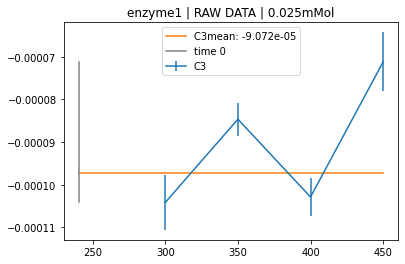

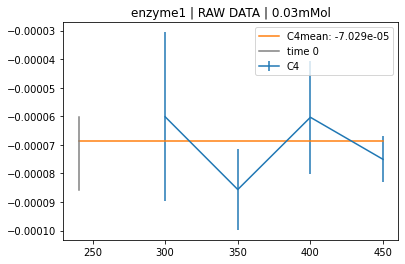

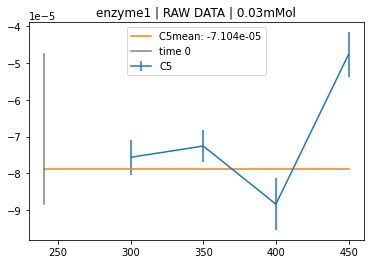

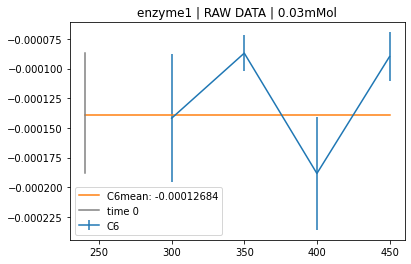

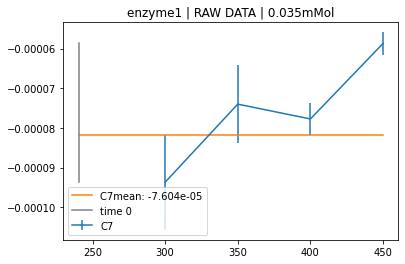

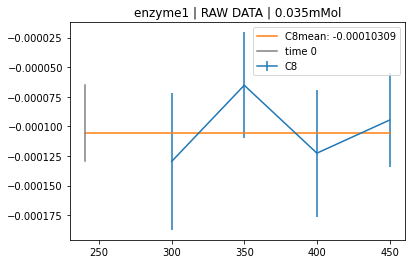

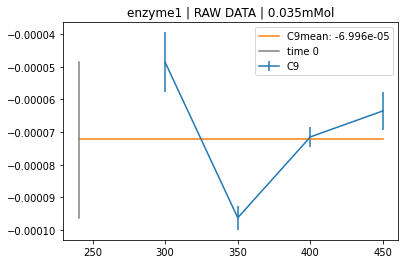

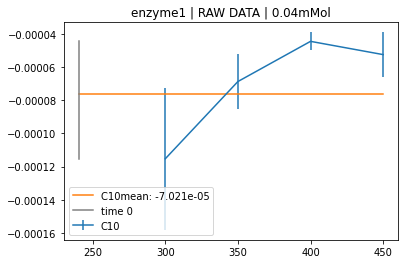

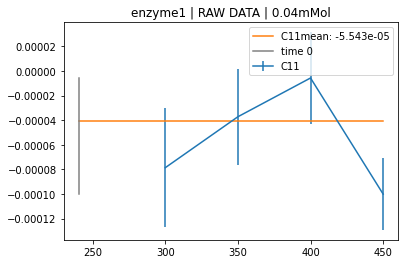

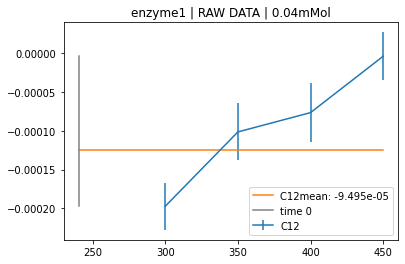

In [45]:
cabp_slopes = analyse_cabp_slopes(dfs1, 
                                  groups, 
                                  cabp_mol, 
                                  slopes, 
                                  errslo)

In [46]:
# pprint.pprint(cabp_slopes, sort_dicts=False)

In [47]:
# change slope manually:

# cabp_slopes['Assay 3 Shaking']['enzyme 1']['D7'] = (-7.046479233911714e-06, [-7.046479233911714e-06])

## plot slopes and concentrations:

exclude assays or enzymes from plotting

xintercept 0.04944944944944945
rvalue^2 0.7785893184738961
baseline -2.0081831567587314e-05


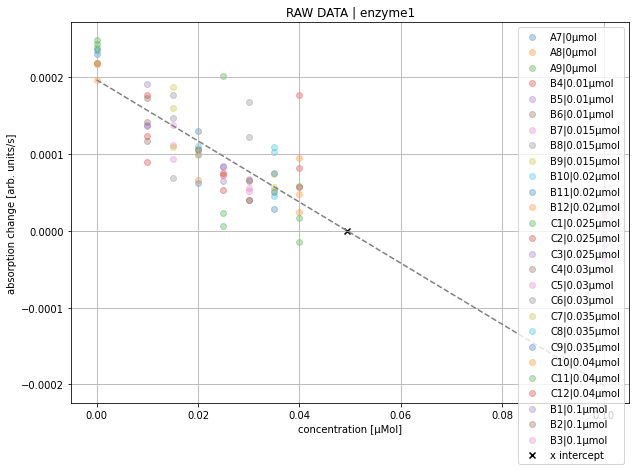

In [48]:
plot_cabp_slopes(cabp_slopes, 
                 cabp_mol, 
                 exclude = [])

# Conversion factor

$l_T$ = pathlength TECAN

$l_N$ = pathlength Nanodrop

$A_T$ = absorbance TECAN

$A_N$ = absorbance Nanodrop

$\beta$ = conversion factor between the instruments

$\beta = \frac{l_T}{l_N} = \frac{A_T}{A_N}$

In [48]:
beta = dict()
for assay in list(cabp_mol):
    beta[assay] = dict()
    change_input = input('want to use assay {}? y/n'.format(assay))
    if change_input.lower() == 'y':
        for enzyme in list(cabp_mol[assay]):
            change_input = input('want to use enzyme {}? y/n'.format(enzyme))
            _list = list()
            if change_input.lower() == 'y':
                beta[assay][enzyme] = dict()
                for well in list(cabp_mol[assay][enzyme]):
                    if cabp_mol[assay][enzyme][well] not in _list:
                        beta[assay][enzyme][well] = float(input('TECAN absorption for {} µMol | {}:\t'.format(cabp_mol[assay][enzyme][well], well)))
                        _list.append(cabp_mol[assay][enzyme][well])
            else:
                pass
    else:
        pass

want to use assay Assay 3 Shaking? y/ny
want to use enzyme Orange? y/ny
TECAN absorption for 0 µMol | E1:	1
TECAN absorption for 0.5 µMol | E3:	2
TECAN absorption for 0.15 µMol | E5:	1
TECAN absorption for 0.1 µMol | E7:	2
TECAN absorption for 0.05 µMol | E9:	1
want to use enzyme Lime? y/n
want to use enzyme SYN6301? y/n
want to use enzyme P_Breve? y/n


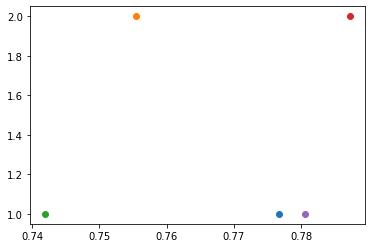

In [51]:
for assay in list(beta):
    for enzyme in list(beta[assay]):
        for well in list(beta[assay][enzyme]):
            plt.scatter(dfs1[assay][well][0], beta[assay][enzyme][well])

# def plot_cabp_conversion(dfs):
    

# Closer look on the triplets data

In [ ]:
trip_mol = {
    
    
}

# TODO


-  [ ] do triplets
- [ ] conversion factor calculation by matching the same concentration on the NADH nanodrop machine: